<span style='color:brown; font-size:32px'>Time Series Analysis of Daily Steps<span/>

## Objective:
To analyze a fitness dataset that contains information about daily steps taken by an individual and identify any recurring parterns, seasonal variations, or anomalies that could help optimize the individual's fitness routine.


<span style='color:brown; font-size:32px'>1.Setup<span/>

In [549]:
import os
import glob
import statistics as st
import scipy.stats as stats
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


<span style='color:brown; font-size:32px'>Data Preparation

We will start by reading the data, clean it and try to get familiar with it.

In [550]:
#DATASET = "Fitness Dataset"                                              
#paths = list(Path(DATASET).glob("*.csv"))
#dfs = [pd.read_csv(p) for p in paths]
#data = pd.concat(dfs, axis=0, ignore_index=True)
#data = data.rename(columns={"Actual": "Steps", "Goal": "Goal"})

#file_name = 'Combined_files.csv'
#data.to_csv(f"./{file_name}")

data = pd.read_csv('Combined_files.csv')

# Clean
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")               # Parse date
data = data.dropna(subset=["Date"]).set_index("Date").sort_index()         # Set index
data["Steps"] = pd.to_numeric(data["Steps"], errors="coerce")              # Ensure numeric
data["Goal"] = pd.to_numeric(data["Goal"], errors="coerce")                # Handle missing values 
data["Steps"] = data["Steps"].interpolate(method="time").ffill().bfill()   # forward-fill then back-fill approach
data["Goal"] = data["Goal"].ffill().bfill()
data = data.asfreq("D")

print("Data shape:", data.shape)

Data shape: (420, 2)


In [551]:
# First 10 rows 
data.head(10)

,Steps,Goal
Date,,
2022-05-31,0,8000
2022-06-01,0,8000
2022-06-02,0,8000
2022-06-03,1102,8000
2022-06-04,1254,8000
2022-06-05,1792,8000
2022-06-06,3723,8000
2022-06-07,1540,8000
2022-06-08,4388,8000


In [552]:
# Bottom row 
data.tail(10)

,Steps,Goal
Date,,
2023-07-15,3151,6500
2023-07-16,6908,6500
2023-07-17,11524,6500
2023-07-18,7049,6500
2023-07-19,10224,6500
2023-07-20,8393,6500
2023-07-21,5954,6500
2023-07-22,9550,6500
2023-07-23,5157,6500


In [553]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2022-05-31 to 2023-07-24
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Steps   420 non-null    int64
 1   Goal    420 non-null    int64
dtypes: int64(2)
memory usage: 9.8 KB


In [554]:
data.isnull().sum()

Steps    0
Goal     0
dtype: int64

From what we can see, the data consists of 15 different csv files with daily steps within 15 months. We used Pandas to read all 15 files in a central location and concatenate them as a single file for our time series analysis. The data was cleaned, time set as index, and we used the forward-fill then back-fill approach to handle missing and NaN values. We will use Descriptive Statistics to understand the data more. 

<span style='color:brown; font-size:32px'>3.Exploratory Data Analysis

In [555]:
columns = ['Steps','Goal']
mean = data[columns].mean()
rounded_mean = round(mean, 2)
print(rounded_mean)


Steps    5674.14
Goal     7682.14
dtype: float64


Average daily steps is 5,674

In [556]:
# median steps
columns = ['Steps']
median = data[columns].median()
rounded_median = round(median, 2)
print(rounded_median)

Steps    5402.0
dtype: float64


In [557]:
# Steps quartiles 
percentiles = np.percentile(data['Steps'], [25, 50, 75])
print('25th Percentile:', percentiles[0])
print('50th Percentile (Median):', percentiles[1])
print('75th Percentile:', percentiles[2])

# Range
a = 3634
b = 7349
IQR = b - a;

print('Middle 50% Steps is:', IQR)

25th Percentile: 3634.0
50th Percentile (Median): 5402.0
75th Percentile: 7349.0
Middle 50% Steps is: 3715


The individual's daily steps are centered around the median of 5,402. This means that on a typical day, you walk just over 5,400 steps. The middle 50% of your activity falls between 3,634 and 7,349 steps, showing a consistent range of daily movement. 3,715 steps represents the Interquartile Range (IQR), which is the difference between the 75th and 25th percentiles, indicating the spread of middle data points.

In [558]:
# Variability
min = data['Steps'].min()
rounded_min = round(min)

max = data['Steps'].max()
rounded_max = round(max)

print('Minimum Steps:',rounded_min)
print('Maximum Steps:',rounded_max)

Minimum Steps: 0
Maximum Steps: 16611


In [559]:
# Variance
variance = np.var(data['Steps'])
rounded_var = round (variance)
print(rounded_var)

8567766


In [560]:
# Standard deviation
std_dev = np.std(data['Steps'])
rounded_std_dev = round(std_dev)
print(rounded_std_dev)

2927


In [561]:
# coefficient of variation (std_dev/mean*100)
C_o_V = 2927 / 5674.14 * 100
print(C_o_V)

51.584909783685276


The standard deviation is about 52% of the mean Steps.

In [562]:
skewness = stats.skew(data['Steps'])
print(skewness)

0.6738307125784117


Positively Skewed(Right).

### Data Visualization

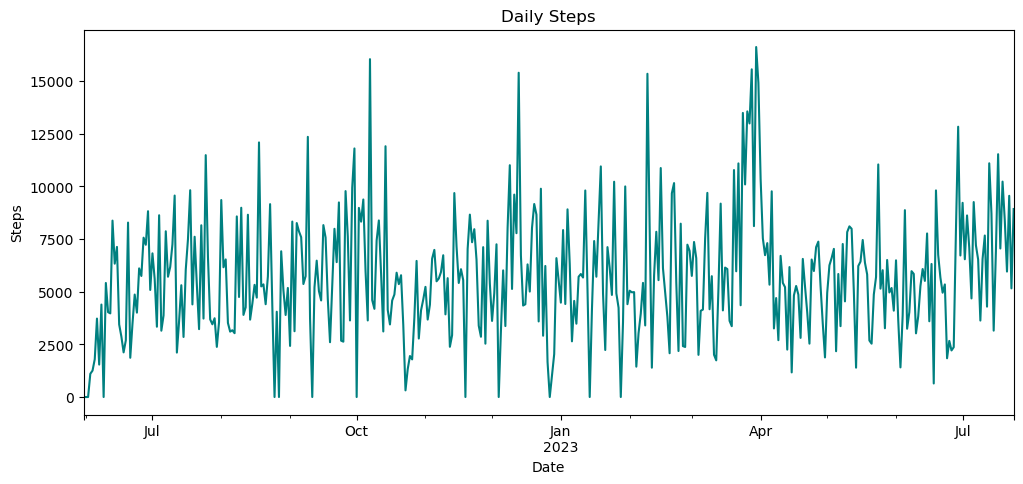

In [630]:
fig = plt.figure(figsize=(12,5))
data["Steps"].plot(title = "Daily Steps", color='teal')
plt.ylabel("Steps")
plt.xlabel("Date")
plt.show()

Looking at the chart, we can see that there is a very visible pattern that repeats itself every 7 days. Therefore, it can be deduced that there is a weekly seasonality within the time series. Let's explore this pattern.

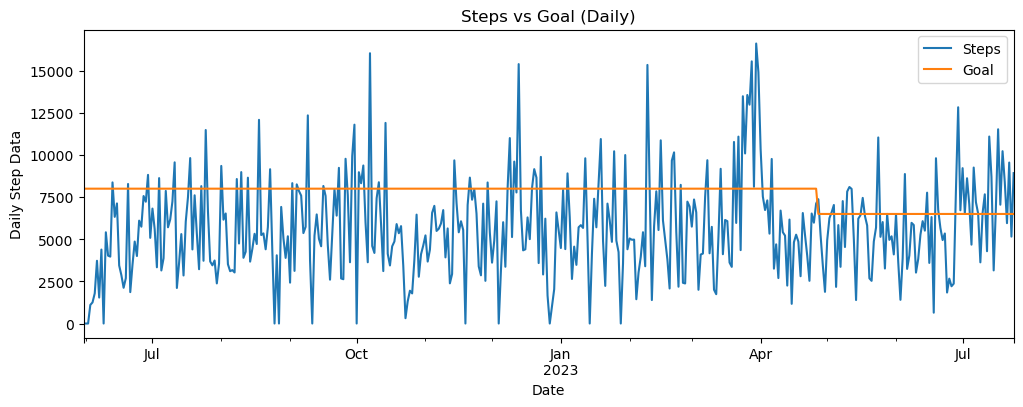

In [626]:
data[['Steps', 'Goal']].plot(title="Steps vs Goal (Daily)", figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Daily Step Data")
plt.show()

<span style='color:brown; font-size:32px'>4. Seasonal Decomposition

Here, we will further investigate the time series by decomposing it into 3 components:

- Trend cycle - increases or decreases in steps in the long term or fix.
- Seasonal - pattern occurs when a time series is affected by seasonal factors.
- Residuals - the remainder after removing the 2 aforementioned components.

We used the Additive Decomposition model. 

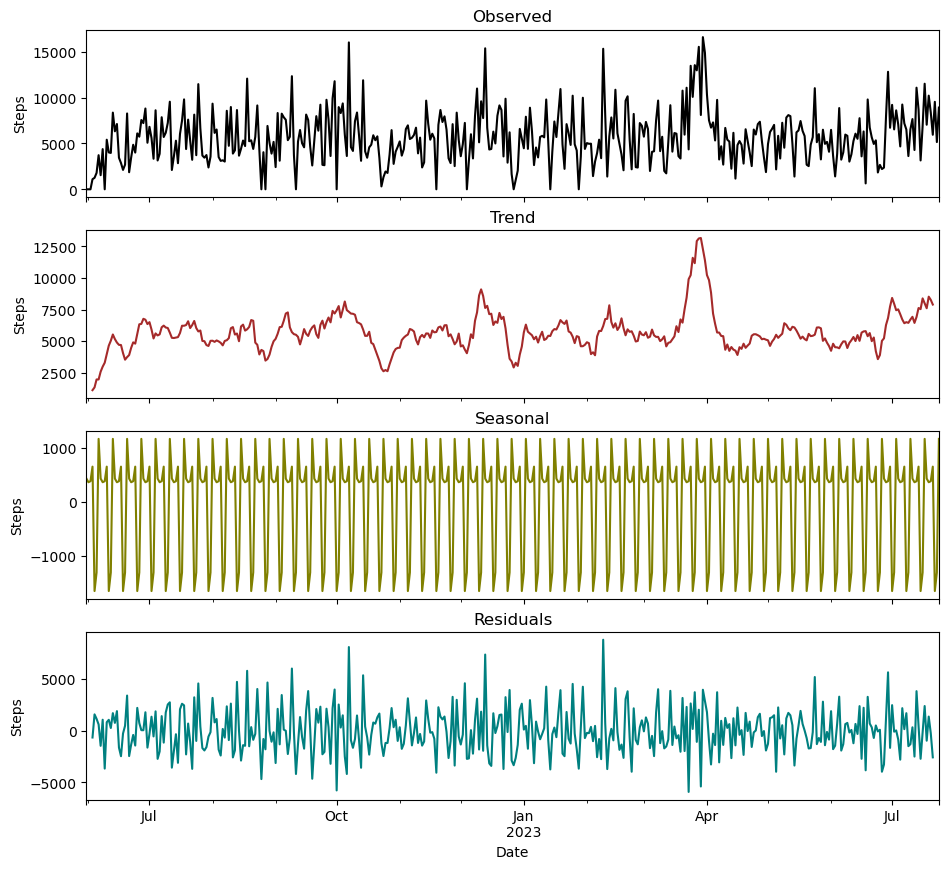

In [629]:
decomposition = seasonal_decompose(data['Steps'], model='additive', period=7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(11, 10), sharex=True)

decomposition.observed.plot(ax=ax1, title='Observed', color='black')
ax1.set_ylabel('Steps')

decomposition.trend.plot(ax=ax2, title='Trend', color='brown')
ax2.set_ylabel('Steps')

decomposition.seasonal.plot(ax=ax3, title='Seasonal', color='olive')
ax3.set_ylabel('Steps')

decomposition.resid.plot(ax=ax4, title='Residuals', color='teal')
ax4.set_ylabel('Steps')

plt.xlabel('Date')
plt.show()


Trends and seasonality of daily steps are clear. The residuals resembles noise or superfluous data.

<span style='color:brown; font-size:32px'>5. Stationarity

In order to select a model, we need to ensure the time series data is stationary. A stationary time series is one whose properties is not dependent on time, with the mean, variance and autocorrelation structure do not change over time. Models such as ARIMA and SARIMA assume the series is stationary.

We will use the Augmented Dickey-Fuller test to test stationarity of the dataset.

In [566]:
def adf_report(series, title="ADF Test"):
    s = series.dropna()
    stat, p, lags, nobs, crit, icbest = adfuller(s, autolag="AIC")
    print(title)
    print(f"  Test Statistic: {stat:.4f}")
    print(f"  p-value:        {p:.6f}")
    print(f"  Lags Used:      {lags}")
    print(f"  Observations:   {nobs}")
    print("  Critical Values:")
    for k, v in crit.items():
        print(f"    {k}: {v:.4f}")
    return stat, p, crit

_ = adf_report(data["Steps"], "ADF Test — Original Steps")

ADF Test — Original Steps
  Test Statistic: -4.8311
  p-value:        0.000047
  Lags Used:      13
  Observations:   406
  Critical Values:
    1%: -3.4466
    5%: -2.8687
    10%: -2.5706


### Interpretation
The p-value is less than 0.05 and the test statistic is more negative compared to the critical values at 1%, 5%, and 10%. We can reject the null hypothesis. Therefore, the time series data has no unit root and is stationary. It does not require differencing before forecasting.

If a series is not stationary, its properties are unpredictable, making it difficult to model and forecast. 

<span style='color:brown; font-size:32px'>6. Model Selection

We now proceed to check the correlation structure within the data using Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.  This step is crucial in order to identify the suitable order of the AR and MA terms, both non-seasonal and seasonal.

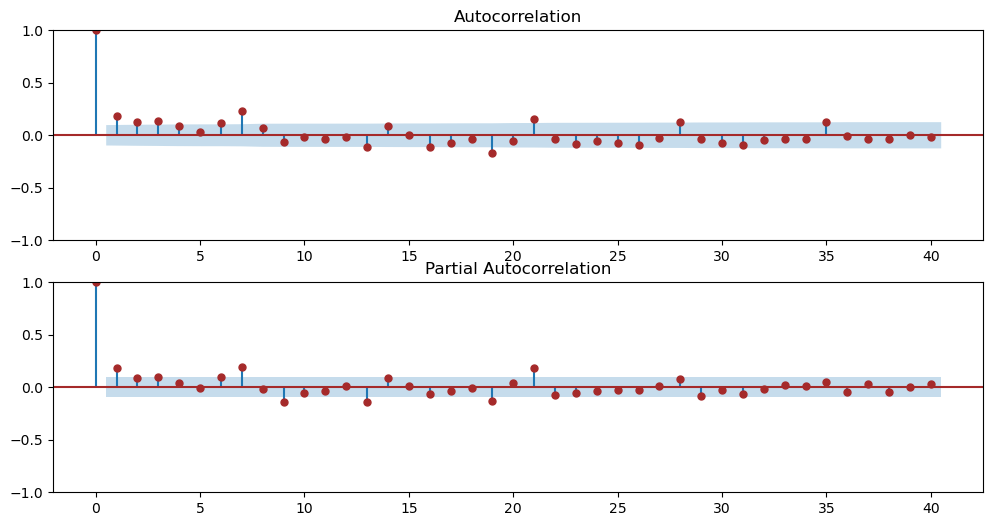

In [621]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Steps'].iloc[13:],lags=40,ax=ax1, color='brown')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Steps'].iloc[13:],lags=40,ax=ax2, color='brown')

Observations

p=1 (AR specification), d=0 (Integration order), q=1(MA specification/polynomial)

(AR specification, Integration order, MA specification)


Although there is seasonability in the data, the ARIMA model will be selected for the forecasting.

### Defining Parameters 

In [546]:
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(data['Steps'],order=(0,1,1))
model_fit=model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Steps   No. Observations:                  420
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3928.661
Date:                Sun, 24 Aug 2025   AIC                           7861.322
Time:                        21:14:15   BIC                           7869.398
Sample:                    05-31-2022   HQIC                          7864.514
                         - 07-24-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8422      0.024    -34.554      0.000      -0.890      -0.794
sigma2      8.145e+06   5.14e+05     15.836      0.000    7.14e+06    9.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                11.62
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.37
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Density plot of residuals.

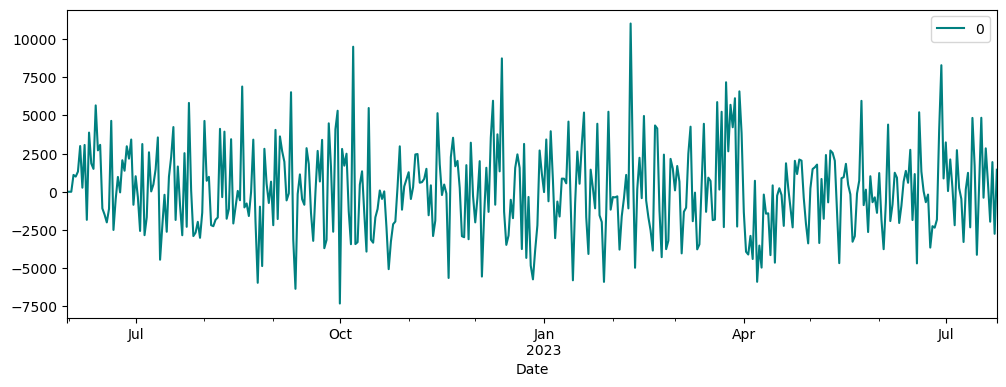

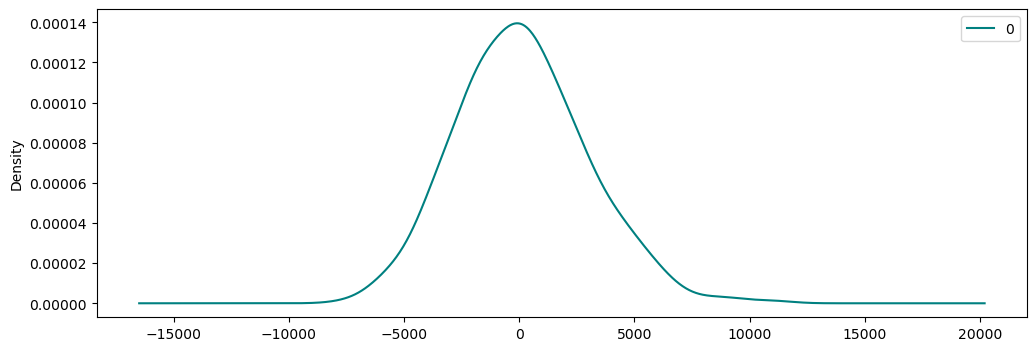

                  0
count    420.000000
mean     111.123089
std     2852.145835
min    -7325.541584
25%    -1849.914471
50%      -10.649772
75%     1858.746453
max    11025.567571


In [628]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(12,4), color='teal')
pyplot.show()

residuals.plot(kind='kde', figsize=(12,4), color='teal')
pyplot.show()

print(residuals.describe())

<span style='color:brown; font-size:32px'>6. Forecasting

In [514]:
forecast_start = pd.Timestamp("2023-06-25")
forecast_end = pd.Timestamp("2024-06-24")
train = data.loc[: forecast_start - pd.Timedelta(days=1)]
test  = data.loc[forecast_start :]

print("Train range:", train.index.min(), "→", train.index.max(), "n =", len(train))
print("Test  range:", test.index.min(),  "→", test.index.max(),  "n =", len(test))


Train range: 2022-05-31 00:00:00 → 2023-06-24 00:00:00 n = 390
Test  range: 2023-06-25 00:00:00 → 2023-07-24 00:00:00 n = 30


<Axes: title={'center': 'Actual vs Forecast'}, xlabel='Date'>

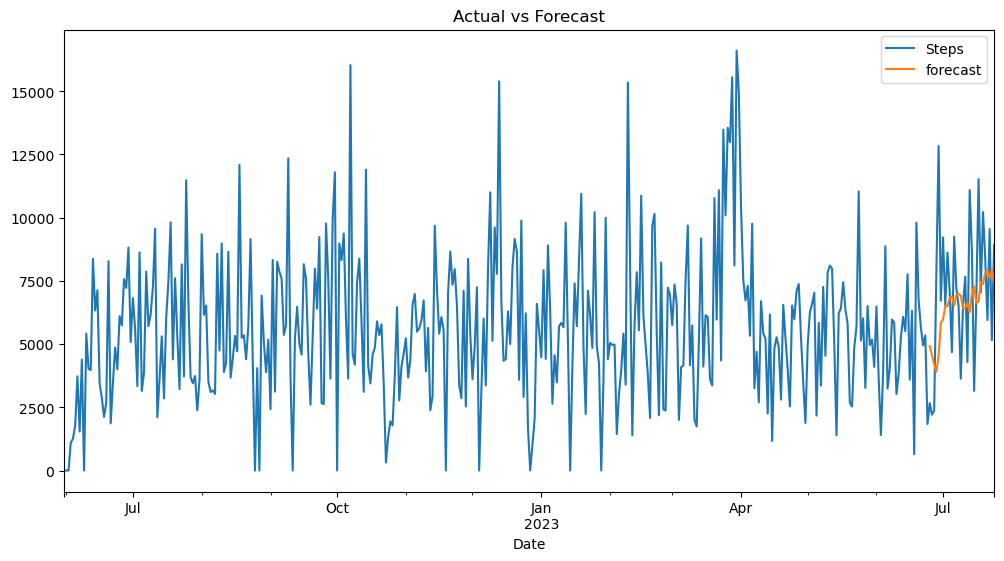

In [603]:
data['forecast']=model_fit.predict(start=forecast_start)
data[['Steps','forecast']].plot(figsize=(12,6), label="Steps", title="Actual vs Forecast")

We also did a SARIMA test to compare, the ARIMA model fits this time series better. 

In [637]:
# Metrics

y_true = test["Steps"]
y_pred = arima_forecast

# Mean Squared Error
mse = mean_squared_error(y_true, y_pred)
print("Mean Squared Error (MSE):", mse)

# R-squared
r2 = r2_score(y_true, y_pred)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 11107473.051322758
R-squared (R²): -0.5306750387175263


<span style='color:brown; font-size:32px'> Forecasting daily Steps for the Next 6 months using ARIMA

In [638]:
from pandas.tseries.offsets import DateOffset

future_dates=[data.index[-1]+ DateOffset(months=x)for x in range(0,6)]

future_datest_data=pd.DataFrame(index=future_dates[1:],columns=data.columns)

future_data=pd.concat([data,future_datest_data])

future_datest_data.tail()

/var/folders/ws/7xrbhbhj6yv54lm6cgd4rv3r0000gn/T/ipykernel_55639/2557864190.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_data=pd.concat([data,future_datest_data])


,Steps,Goal,forecast
2023-08-24,NaN,NaN,NaN
2023-09-24,NaN,NaN,NaN
2023-10-24,NaN,NaN,NaN
2023-11-24,NaN,NaN,NaN
2023-12-24,NaN,NaN,NaN


<Axes: >

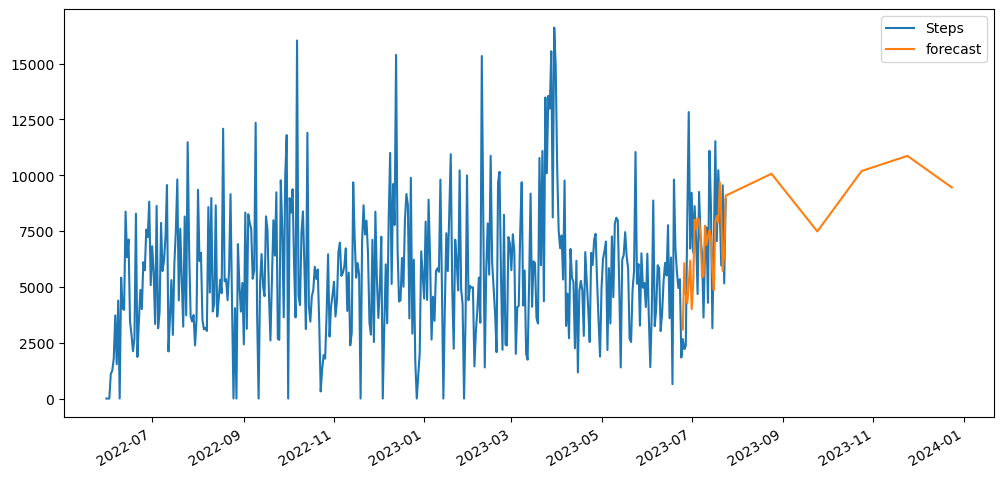

In [639]:
future_data['forecast'] = results.predict(start = forecast_start, end = forecast_end)  
future_data[['Steps', 'forecast']].plot(figsize=(12, 6)) 

<span style='color:brown; font-size:32px'> Reflections

Working through this time series forecasting exercise gave me practical insight into how important data preparation is before applying any model. At the start, I had to consolidate multiple files into one dataset, deal with missing dates, and ensure that the Steps values were properly formatted as numeric. In the datasets, this column was "Actual". I used forward/backward filling since time series models do not work well with missing values. This process showed me that even before thinking about models, the accuracy of the final results depends heavily on how well the data is cleaned and structured. Indexing by date was crucial for making the data usable.

The analysis stage reinforced how time series data behaves differently from other data types. I used decomposition to identify both trend and seasonality, and the ADF test helped check whether the series was stationary, revealing a weekly pattern in the steps data, where weekends showed different activity levels compared to weekdays. Such patterns justified using seasonal models. I experimented with Holt–Winters, SARIMA, and ARIMA, and then compared their performance. Interestingly, the ARIMA model ended up fitting the data best, which taught me that even though seasonality is present, simpler models can sometimes capture the structure more effectively depending on the dataset. 

The dataset showed trends and seasonality but I decided to use ARIMA because it fit my model. I believe what I will do next is to experiment more on SARIMA as I struggled to make it fit. Also, I realised I do not have a base model which I will look more into. Metrics like Mean Squared Error and R-squared gave a clearer picture of which model performed best, but plotting forecasts and residuals made the results more intuitive.

A copy of this notebook has been uploaded on Github with a link below.

<span style='color:brown; font-size:32px'>Github Link

https://github.com/Francis-Dadzie/Jupyter-Notebook.git